In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from symfit import Variable, Parameter, parameters, Fit, exp, pi, sqrt
from symfit.distributions import Gaussian
from symfit.core.models import CallableModel

from functools import reduce
from operator import add


In [2]:
df = pd.read_excel("peptide 24_32_4Cfolding_ppiA.xlsx", skiprows=[0, 1], header=[0])
df = df.dropna(how='any')
df.size
len(df.index)

655

In [8]:
df = pd.read_excel("peptide 24_32_4Cfolding_ppiA.xlsx", skiprows=[0, 1], header=[0])
df = df.dropna(how='any')

series_dict = {}
for i, col in enumerate(df):
    if i % 2 == 0:
        idx = df.iloc[:, i]
        data = df.iloc[:, i + 1]
        data.index = idx
        data /= np.trapz(data, data.index)

        series_dict[data.name] = data

In [9]:
series_dict.keys()

dict_keys(['FD_1', 'FD_2', 'FD_3', 'FD_4', 'FD_5', 'T0_1', 'T0-2', 'T0_3', 'T0-4', 'T0-5', '5sec_1', '5sec_2', '5sec_3', '10sec_1', '10sec_2', '10sec_3', '10sec_4', '10sec_5', '10sec_6', '20sec_1', '20sec_2', '20sec_3', '20sec_4', '20sec_5', '40sec_1', '40sec_2', '40sec_3', '40sec_4', '40sec_5', '40sec_6', '40sec_7', '1min_1', '1min_2', '1min_3', '1min_4', '1min_5', '1min_6', '2.5min_1', '2.5min_2', '2.5min_3', '5min_1', '5min_2', '5min_3', '10min_1', '10min_2', '10min_3', '10min_4', '10min_5', '15min_1', '15min_2', '15min_3', '15min_4', '20min_1', '20min_2', '20min_3', '30min_1', '30min_2', '30min_3', '45min_1', '45min_2', '45min_3', '1hr_1', '1hrs_2', '1hr_3', '3hrs_1', '16hrs_1', 'Native_1', 'Native_2', 'Naïve_3'])

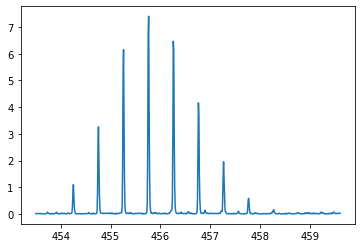

In [56]:
s = series_dict['5sec_1']
fig, ax = plt.subplots()
ax.plot(s.index, s)


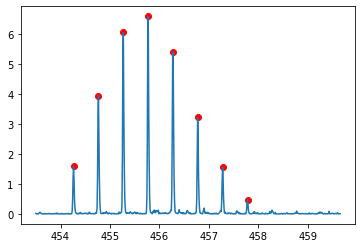

In [27]:
idx = find_peaks(s, prominence=0.25)[0]

xp = s.index.to_numpy()[idx]
yp = s.to_numpy()[idx]

fig, ax = plt.subplots()
ax.plot(s.index, s)
ax.scatter(xp, yp, color='r')

In [39]:
#optional: otsu thds
n = 2
vals =np.linspace(xp.min(), xp.max(), num=2*n+1, endpoint=True)

x_pos = vals[1::2]
x_sig = 2*np.diff(xp).mean()
amp = [yp[np.argmin(np.abs(_x - xp))] for _x in x_pos]



In [40]:
x_var = Variable('x')
y_var = Variable('y')

guassians = []
for i in range(n):
    print(i)
    a_par, mu_par, sig_par = parameters(f'a_{i} mu_{i} sigma_{i}')
    a_par.value = amp[i]
    mu_par.value = x_pos[i]
    sig_par.value = x_sig

    gauss = a_par*exp(-(x_var - mu_par)**2/(2*sig_par**2))
    guassians.append(gauss)

0
1


In [41]:
reduce(add, guassians)

model = CallableModel({y_var: reduce(add, guassians)})
model


In [42]:
fit = Fit(model, x=xp, y=yp)
fit_result = fit.execute()
print(fit_result)

Scalar Parameters:
Parameter | Value       | Standard Deviation
a_0         2.015512e+00  None
a_1         5.398891e+00  None
mu_0        4.551539e+02  None
mu_1        4.559040e+02  None
sigma_0     6.402691e-01  None
sigma_1     8.547538e-01  None
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   65
Objective              <symfit.core.objectives.LeastSquares object at 0x0000027E652ECCF8>
Minimizer              <symfit.core.minimizers.BFGS object at 0x0000027E652ECE48>

Goodness of fit qualifiers:
chi_squared            0.017417132175374814
objective_value        0.008708566087687407
r_squared              0.9995239362878895


In [49]:
x_vec = np.linspace(s.index.min(), s.index.max(), num=100, endpoint=True)
y_vec = model(x=x_vec, **fit_result.params)
y_vec[0][0]

0.1741895846994604

3.2189095516940247
11.538923994426412


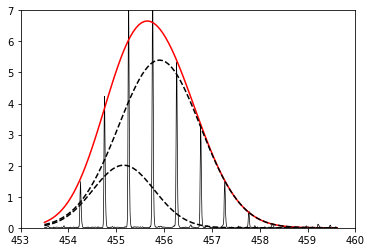

In [51]:

fig, ax = plt.subplots()
ax.plot(s.index, s, color='k',linewidth=0.7)
#ax.scatter(xp, yp, color='r')
ax.plot(x_vec, y_vec[0], color='r')
ax.set_ylim (0,7)
ax.set_xlim(453,460)

for g in guassians:
    y_g = g(x=x_vec, **fit_result.params)
    ax.plot(x_vec, y_g, color='k', linestyle='--')
    integral = np.trapz(y_g, x_vec)
    print(integral)
#plt.savefig('4C_3h.png')

#ax.axvline(centroid, color='g')